In [90]:
import sys
sys.path.append('../..')
import pennylane.numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

In [91]:
from qubap.pennylane.costfunc_barren_plateau import global2local, test_hamiltonian_2
from qubap.pennylane.variational_algorithms import VQE
from qubap.pennylane.state_efficient_ansatz_pennylane import ansatz_constructor

We provides an early implementation of the local-global VQE and the State Efficient Ansatz for __Penylane__. We are going to optimize the following hamiltonian.

In [92]:
num_wires = 6
hamiltonian = test_hamiltonian_2( num_wires, [0,0,1] )
print( hamiltonian )

  (0) [X0 X1 X2 X3 X4 X5]
+ (0) [Y0 Y1 Y2 Y3 Y4 Y5]
+ (1) [Z0 Z1 Z2 Z3 Z4 Z5]


Calculating the local Hamiltonian.

In [93]:
hamiltonian_local = global2local( hamiltonian )
print(hamiltonian_local)

  (0.0) [X0]
+ (0.0) [X1]
+ (0.0) [X2]
+ (0.0) [X3]
+ (0.0) [X4]
+ (0.0) [X5]
+ (0.0) [Y0]
+ (0.0) [Y1]
+ (0.0) [Y2]
+ (0.0) [Y3]
+ (0.0) [Y4]
+ (0.0) [Y5]
+ (0.0) [I0]
+ (0.16666666666666666) [Z0]
+ (0.16666666666666666) [Z1]
+ (0.16666666666666666) [Z2]
+ (0.16666666666666666) [Z3]
+ (0.16666666666666666) [Z4]
+ (0.16666666666666666) [Z5]


Creating the variational circuit.

In [94]:
def ansatz(params, num_layers=0):
    
    num_wires = len(params)//(2*num_layers+2)

    K = 0
    for i in range(num_layers):
        qml.broadcast( qml.RY, wires=range(num_wires), pattern='single', parameters=params[K:K+num_wires] )
        qml.broadcast( qml.RZ, wires=range(num_wires), pattern='single', parameters=params[K+num_wires:K+2*num_wires] )
        qml.broadcast( qml.CNOT, wires=range(num_wires), pattern='ring')
        K = K+2*num_wires

    qml.broadcast( qml.RY, wires=range(num_wires), pattern='single', parameters=params[K:K+num_wires] )
    qml.broadcast( qml.RZ, wires=range(num_wires), pattern='single', parameters=params[K+num_wires:K+2*num_wires] )

Choosing SPSA as optimizer.

In [95]:
optimizer = qml.SPSAOptimizer(maxiter=1000)
maxiter   = 300

Defining a device.

In [96]:
dev = qml.device("default.qubit", wires=num_wires)
@qml.qnode(dev)
def cost_func(params):
    ansatz(params)
    return qml.expval(hamiltonian)

Runing the VQEs.

In [97]:
np.random.seed(100)
params_in = np.random.randn( 2*num_wires )*np.pi
params_out, energies_global = VQE( hamiltonian, ansatz, params_in, optimizer, shots=2**6, max_iterations=maxiter )

In [98]:
np.random.seed(100)
params_in = np.random.randn( 2*num_wires )*np.pi
params_out, energies_local  = VQE( hamiltonian_local, ansatz, params_in, optimizer, shots=2**6, max_iterations=maxiter//2)
energies_global_from_local = [ cost_func(x) for x in params_out ]

In [ ]:
np.random.seed(100)
params_in = np.random.randn( 6*num_wires )*np.pi
params_out, energies_global_after_local = VQE( hamiltonian, ansatz, params_out[-1], optimizer, shots=2**6, max_iterations=maxiter//2 )

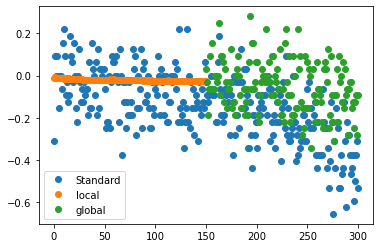

In [ ]:
plt.plot( energies_global, 'o' )
plt.plot( energies_global_from_local, 'o' )
plt.plot( range(maxiter//2,maxiter+1), energies_global_after_local, 'o' )
plt.legend([ 'Standard', 'local', 'global']) 


We also implement the Efficient State Ansatz.

In [ ]:
n_qbits = num_wires
reps    = 1
SEA = ansatz_constructor(n_qbits , deep=[reps,reps,reps])

num_params_SEA = ( reps +1 )*n_qbits + reps*(n_qbits - 2)

params_SEA = [ np.random.randn( num_params_SEA )*np.pi for _ in range(3) ]

In [ ]:
par, results_SEA = VQE(hamiltonian, SEA, params_SEA, optimizer, shots=2**6, max_iterations=maxiter)

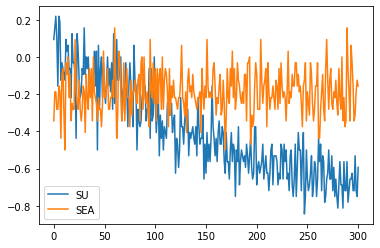

In [ ]:
plt.plot( energies_global, label='SU' )
plt.plot( results_SEA, label='SEA' )
plt.legend(  )

Our current implementation is not able to outperforme barren plateaus. We think that improve our VQE and the classical optimizer is mandatory to obtain better results. This is a first step to have this routines in Pennylane.